# PROPOSAL and EcoMug - underground water muography simulation

how to run the simulation:
1. everything is configured in `config.py`
2. run in two seperate terminals:
* `dask scheduler`
* `dask worker localhost:8786` (important! run in `/computation`) 
* `dask worker localhost:8786 --nworkers 23 --nthreads 1 --memory-limit="4 GiB" --local-directory /tmp` (optimized for TU Dortmund phobos server)
3. continue with cells below


The `config.py` is currently set to a realistic simulation of the 3D Detector.
Furthermore the parameter `v_cut` from PROPOSAL is very time sensitive. (increase for quicker, but less accurate simulations of PROPOSAL)

In [1]:
# Set hdf_folder in config!
# !mkdir data_hdf

now you can run the next two cells where it first creates a file with all muons needed with EcoMug, then propagates them with PROPOSAL in the second cell

In [2]:
# dont forget to set the correct env variables!
# !export PYTHONPATH="$HOME/muography2/computation:$PYTHONPATH"
# !export LD_LIBRARY_PATH="/scratch/mschoenfeld/envs/muo_23/lib:$LD_LIBRARY_PATH"
# conda env config vars set PYTHONPATH="$HOME/muography2/computation/EcoMug_pybind11/build"
# conda env config vars set LD_LIBRARY_PATH="/scratch/mschoenfeld/envs/3.11/lib"

In [8]:
!python d_EM.py

/bin/bash: /scratch/mschoenfeld/envs/3.11/lib/libtinfo.so.6: no version information available (required by /bin/bash)
generating gaisser_plots/EcoMug_1e6_gaisser_min8_max4e3_75deg_3D.hdf
calculate muons with EcoMug took     6.3 s
Total time: 0.2 min


In [65]:
!python d_pp.py

/bin/bash: /scratch/mschoenfeld/envs/3.11/lib/libtinfo.so.6: no version information available (required by /bin/bash)
test3/EcoMug_1e6_gaisser_min730_max3e5_60deg_3D.hdf | N_tasks = 23
PROPOSAL config = kirchhellen_AVG_3D_840m.json, vcut=0.001_MoliereInterpol
propagating muons with PROPOSAL took   251.9 s
(92.0) of 1e+06 (0.0092)% detector hits | min(E_i) at detector = 824.4 GeV


# Muon flux plots - EcoMug

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from importlib import reload
import py_library.my_plots_library as plib
import py_library.stopwatch as stopwatch
import py_library.simulate_lib as slib
import config as cfg

# os.chdir(os.path.dirname(__file__))
reload(cfg)
reload(slib)
reload(plib)
reload(stopwatch)

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams.update({'figure.dpi':70})

df_EM = pd.read_hdf(cfg.hdf_folder+cfg.file_name, key='main')
print(cfg.file_name)

test3/EcoMug_1e6_gaisser_samp_0.6_min730_max3e5_60deg_3D.hdf


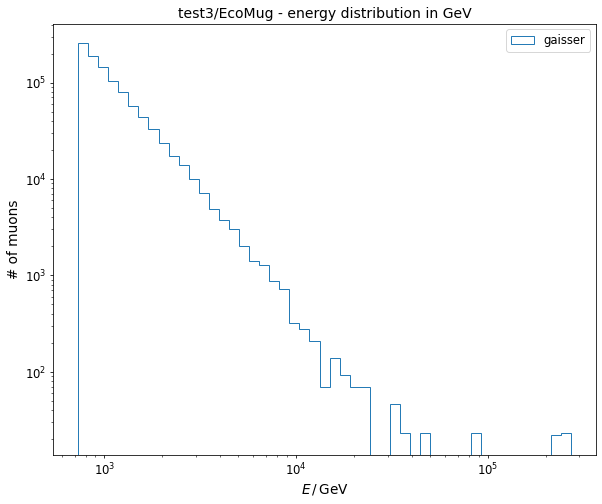

In [20]:
# EcoMug: energy distribution
plib.plot_hist(
    df_EM['energy'], 
    name=f'{cfg.subfolder}EcoMug - energy distribution in GeV',
    label='gaisser' ,
    ylabel = '# of muons',
    xlabel1 = 'E',
    xlabel2 = 'GeV',
    xlog=True,
    binsize=50,
    show_or_multiplot='show',
    savefig=False,
    histtype='step')

In [18]:
reload(cfg)

180-np.degrees(df_EM['theta'].max()), cfg.min_theta

(56.0, 56)

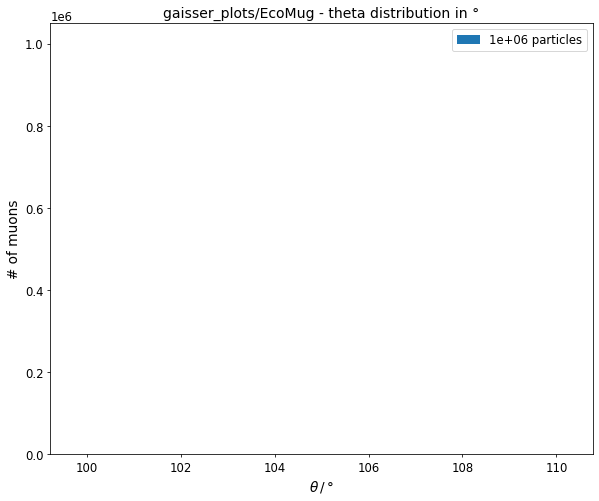

In [10]:
# EcoMug: theta distribution in °
plib.plot_hist(
    np.degrees(df_EM['theta']), 
    name=f'{cfg.subfolder}EcoMug - theta distribution in °',
    ylabel = '# of muons',
    xlabel1 = r'\theta',
    xlabel2 = '°',
    xlog=False,
    binsize=30,
    show_or_multiplot=cfg.show_or_multiplot,
    savefig=True)

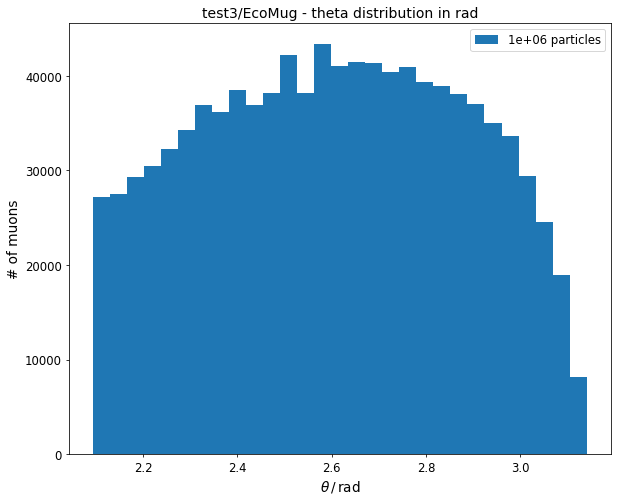

In [22]:
# EcoMug: theta distribution in rad
plib.plot_hist(
    df_EM['theta'], 
    name=f'{cfg.subfolder}EcoMug - theta distribution in rad',
    ylabel = '# of muons',
    xlabel1 = r'\theta',
    xlabel2 = 'rad',
    xlog=False,
    binsize=30,
    show_or_multiplot=cfg.show_or_multiplot,
    savefig=True)

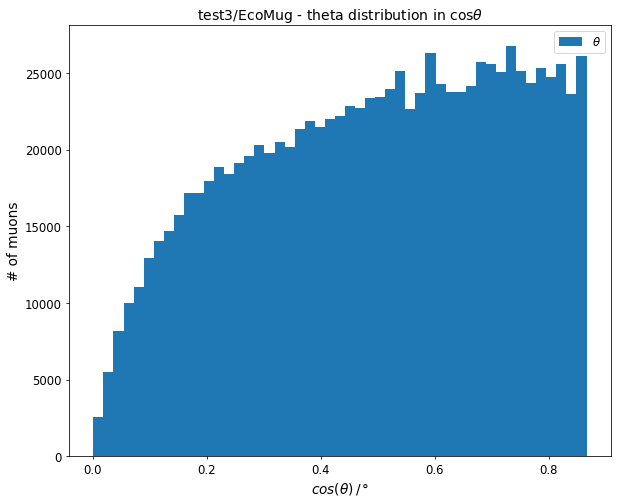

In [23]:
# EcoMug: theta distribution in cos(theta)
a = 1/2*np.pi - df_EM['theta']
plib.plot_hist(
    np.cos(a), 
    ylabel='# of muons',
    xlabel1=r'cos(\theta)',
    xlabel2='°',
    name=fr'{cfg.subfolder}EcoMug - theta distribution in cos$\theta$',
    label=r'$\theta$',
    xlog=False,
    binsize=50,
    show_or_multiplot=True,
    savefig=True)

myons with more than 600 GeV = 1000000 (100.00%)


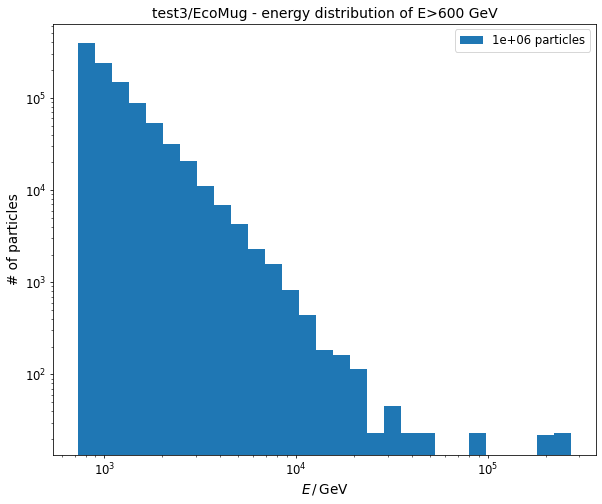

In [24]:
# looking how many muons are over energy_threshold for setting the energy threshold
energy_threshold = 600  # GeV
a = []
for i in df_EM['energy']:
    if (i>energy_threshold):
        a.append(i)

len_a = len(a)
print(f'myons with more than {energy_threshold} GeV = {len_a} ({len_a/cfg.STATISTICS*100:.2f}%)')
if len_a > 100:
    plib.plot_hist(
        a, 
        name=f'{cfg.subfolder}EcoMug - energy distribution of E>{energy_threshold} GeV',
        xlabel1 = 'E',
        xlabel2 = 'GeV',
        show_or_multiplot=cfg.show_or_multiplot,
        xlog=True,
    )


# PROPOSAL Plots

In [25]:
df_pp = pd.read_hdf(cfg.hdf_folder+cfg.file_name_results, key='main')

In [26]:
cfg.hdf_folder+cfg.file_name_results

'/scratch/mschoenfeld/data_hdf/test3/kirchhellen_AVG_3D_840m.json_vcut=0.001_MoliereInterpol_EcoMug_1e6_gaisser_min730_max3e5_60deg_3D.hdf'

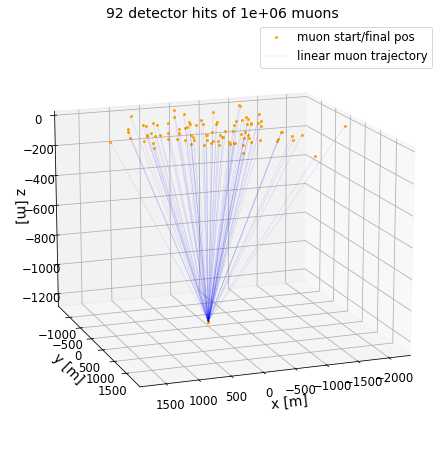

In [27]:
# 3D plot
reload(cfg)
load_lines = 1200
df = pd.read_hdf(cfg.hdf_folder+cfg.file_name_results, key='main', stop=load_lines)
if len(df) < load_lines:
    load_lines = len(df)

start_points = np.zeros(shape=(load_lines, 3), dtype=np.float64)
end_points = np.zeros(shape=(load_lines, 3), dtype=np.float64)
start_end_points = np.zeros(shape=(load_lines*2, 3), dtype=np.float64)

for i in range(load_lines):
    start_points[i] = [df['point1x'][i], df['point1y'][i], df['point1z'][i]]
    end_points[i] = [df['point2x'][i], df['point2y'][i], df['point2z'][i]]
    start_end_points[i*2] = start_points[i]
    start_end_points[i*2+1] = end_points[i]
# start_end_points = df['start_end_points']
plib.plot_3D_start_end(
    start_end_points/100,
    elev=15, azim=70, alpha=0.14, dpi=1, show=cfg.show_plots,
    title=f'{load_lines} detector hits of {cfg.STATISTICS:.0e} muons',
    name=f'{cfg.subfolder}PP - 3D_start_end')

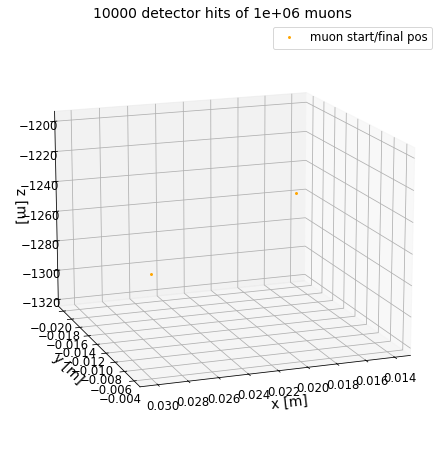

In [28]:
load_lines = int(1e4)
df = pd.read_hdf(cfg.hdf_folder+cfg.file_name_results, key='main', stop=load_lines)
df = df[df['point2z'] <= cfg.detector_bottom_depth]
df['point2z'] = -125900

reload(plib)

end_points = np.column_stack((df['point2x'], df['point2y'], df['point2z']))
plib.plot_3D_end(
    end_points/100,
    elev=15, azim=70, alpha=0.14, dpi=1, show=cfg.show_plots,
    title=f'{load_lines} detector hits of {cfg.STATISTICS:.0e} muons',
    name=f'{cfg.subfolder}PP - 3D_start_end')

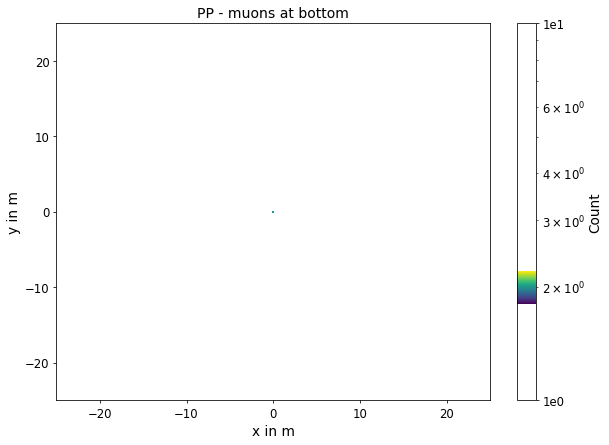

In [29]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib import ticker

load_lines = int(1e7)
df = pd.read_hdf(cfg.hdf_folder + cfg.file_name_results, key='main', stop=load_lines)
df = df[df['point2z'] <= cfg.detector_bottom_depth]

x = df['point2x'] / 100
y = df['point2y'] / 100

# Create a 2D histogram using numpy
bin_size = 200  # Adjust the bin size as needed
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

edge = 25
xmin = -edge
xmax = edge
ymin = -edge
ymax = edge

xbins = np.linspace(xmin, xmax, bin_size)
ybins = np.linspace(ymin, ymax, bin_size)

# plot with LogNorm applied and range specified
plt.figure(figsize=(10, 7))
plt.hist2d(x, y, bins=[xbins, ybins], cmap='viridis', norm=LogNorm())

cbar = plt.colorbar(format=LogFormatter(10))
cbar.set_label('Count')

plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('PP - muons at bottom')

# code to adjust colorbar ticks
cbar_ticks = cbar.get_ticks()[1:-1]
new_labels = ['1e{}'.format(int(np.log10(tick))) for tick in cbar_ticks]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(new_labels)

plt.savefig(f'figures/{cfg.subfolder}PP - Bottom Histogram')

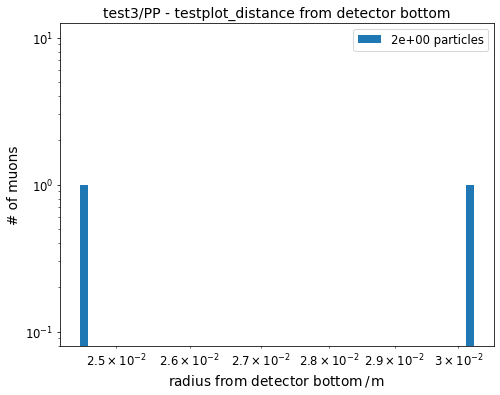

In [30]:
# distance from ground zero (detector)
filtered_df = df_pp[df_pp['point2z'] <= cfg.detector_bottom_depth]

x = filtered_df['point2x']
y = filtered_df['point2y']

r = np.sqrt(x**2 + y**2) / 100

# histogram of 

plib.plot_hist(
    r, 
    name=f'{cfg.subfolder}PP - testplot_distance from detector bottom',
    ylabel = '# of muons',
    xlabel1 = r'\text{radius from detector bottom}',
    xlabel2 = 'm',
    xlog=True,
    binsize=50,
    show_or_multiplot='show',
    savefig=True)

In [31]:
outer_radius = 8.75
count_over_100 = np.sum(r > outer_radius)

# Total number of elements in the array
total_elements = r.size

# Calculate the percentage
percentage_over_100 = (count_over_100 / total_elements) * 100

print(f"Percentage of values over {outer_radius}: {percentage_over_100:.4} %")

Percentage of values over 8.75: 0.0 %


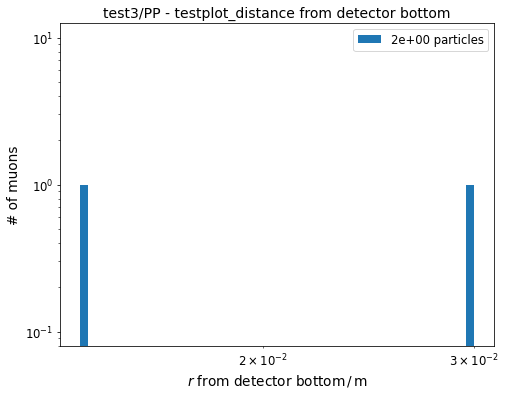

In [32]:
# distance from ground zero (detector)
filtered_df = df_pp[df_pp['point2z'] <= cfg.detector_bottom_depth]

x = filtered_df['point2x'][filtered_df['point2x'] >= 0]
x = x[x <= 30 * 1e2]

# histogram of 

plib.plot_hist(
    x/100, 
    name=f'{cfg.subfolder}PP - testplot_distance from detector bottom',
    ylabel = '# of muons',
    xlabel1 = r'r \text{ from detector bottom}',
    xlabel2 = 'm',
    xlog=True,
    binsize=50,
    show_or_multiplot='show',
    savefig=True)

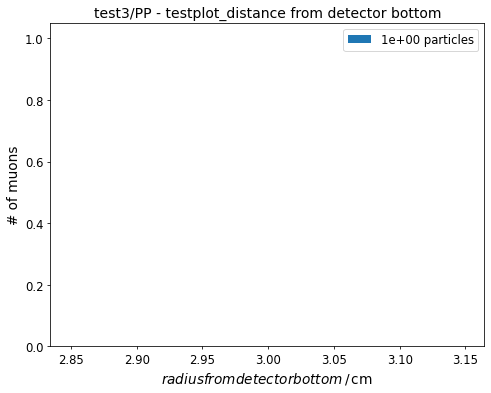

In [33]:
x_ = abs(x)
filtered_x = x_[(x_ >= 2) & (x_ <= 10)]
plib.plot_hist(
    filtered_x, 
    name=f'{cfg.subfolder}PP - testplot_distance from detector bottom',
    ylabel = '# of muons',
    xlabel1 = 'radius from detector bottom',
    xlabel2 = 'cm',
    xlog=False,
    binsize=50,
    show_or_multiplot='show',
    savefig=False)

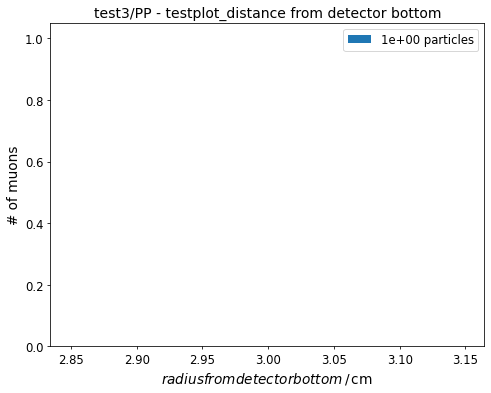

In [34]:
x_ = abs(x)
filtered_x = x_[(x_ >= 2) & (x_ <= 10)]
plib.plot_hist(
    filtered_x, 
    name=f'{cfg.subfolder}PP - testplot_distance from detector bottom',
    ylabel = '# of muons',
    xlabel1 = 'radius from detector bottom',
    xlabel2 = 'cm',
    xlog=False,
    binsize=50,
    show_or_multiplot='show',
    savefig=False)

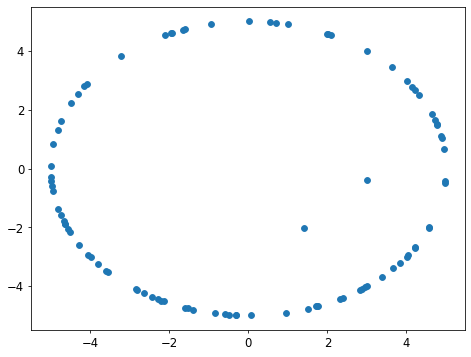

In [35]:
x = df_pp['point2x']
y = df_pp['point2y']

plt.scatter(x, y)

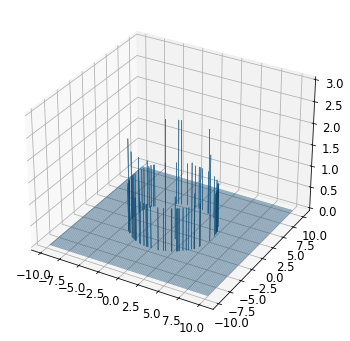

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 10
bins = 200
hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[-r, r], [-r, r]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = r/bins * np.ones_like(zpos)
dz = hist.ravel()
# dz = np.log(hist.ravel() + 1)  # Adding 1 to avoid log(0)


ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.savefig(f'figures/{cfg.subfolder}PP - testplot_distance 3D from detector bottom.pdf', bbox_inches="tight")

In [37]:
# 3D plot end points close up look

# counter = len(df_pp['point1x'])
# if (counter>2000):
#     end = 2000
# else:
#     end = counter

# end_points = np.zeros(shape=(counter, 3), dtype=np.float64)

# for i in range(end):
#     end_points[i] = [df_pp['point2x'][i], df_pp['point2y'][i], df_pp['point2z'][i]]

# plib.plot_3D_start_end(
#     end_points/100,
#     elev=15, azim=70, alpha=0.14, dpi=1, show=cfg.show_plots,
#     title=f'end points close up look',
#     name=f'PP - 3d_only_end'
# )

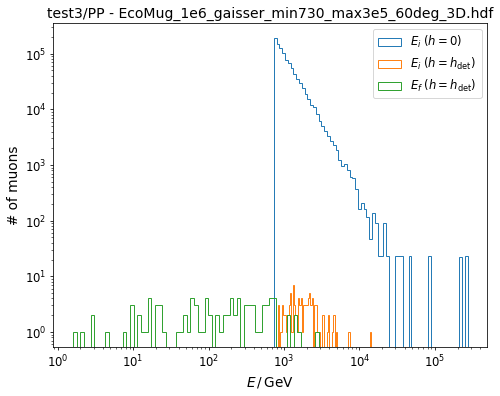

In [38]:
plt.rcParams['figure.figsize'] = (8, 6)
# Initial energy of the muons (blue)
plib.plot_hist(
    df_EM['energy'], 
    label=r'$E_i \;(h=0)$',
    binsize=70,
    xlog=True,
    show_or_multiplot='multi',
    histtype='step'
)
# Initial energy of the muons that arrived at the detector (orange)
bins_energies_i = plib.plot_hist(
    df_pp['energies_i']/1000, 
    label=r'$E_i \;(h=h_{\mathrm{det}})$',
    xlog=True,
    binsize=70,
    show_or_multiplot='multi',
    histtype='step'
)
# Final energy of the muons that arrived at the detector (orange)
plib.plot_hist(
    df_pp['energies_f']/1000, 
    name=f'{cfg.subfolder}PP - {cfg.file_name_}',
    ylabel = '# of muons',
    xlabel1 = 'E',
    xlabel2 = 'GeV',
    label=r'$E_f \;(h=h_{\mathrm{det}})$',
    show_or_multiplot='show',
    xlog=True,
    binsize=70,
    savefig=True,
    histtype='step'
)

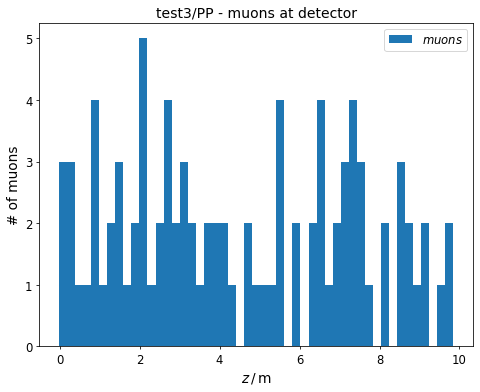

In [39]:
# muons at detector in detector coordinates
a = (df_pp['point2z'] - (cfg.detector_pos[2] - cfg.detector_height/2))/100
plib.plot_hist(
    a,
    ylabel = '# of muons',
    xlabel1 = 'z',
    xlabel2 = 'm',
    label=r'$muons$',
    name=f'{cfg.subfolder}PP - muons at detector',
    xlog=False,
    binsize=50,
    histtype='bar'
)

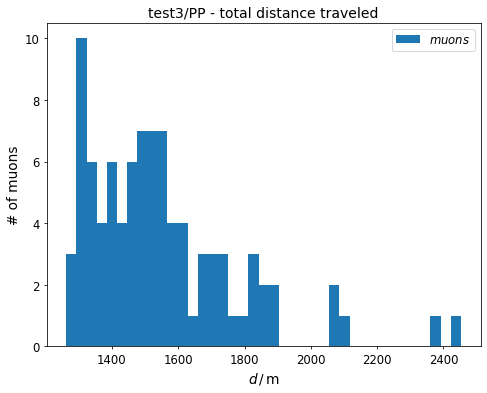

In [40]:
# total distance traveled
plib.plot_hist(
    df_pp['distances']/100, 
    name=f'{cfg.subfolder}PP - total distance traveled',
    ylabel = '# of muons',
    xlabel1 = 'd',
    xlabel2 = 'm',
    label=r'$muons$',
    xlog=False,
    binsize=40,
    savefig=True,
    histtype='bar'
)

# Calculate Detector Rate

In [41]:
# calculate a muon flux of a given detector at sea level (using gaisser function)
from scipy.integrate import tplquad
from uncertainties import ufloat
reload(cfg)

emin = float(cfg.min_E)
emax = float(cfg.max_E)
thetamin = float(cfg.min_theta)
thetamax = float(cfg.max_theta)

# emin = 1e
# emax = 1e2
# thetamin = 0
# thetamax = 90

f = lambda theta, phi, E: 0.14*E**(-2.7)*(
                    1    /(1 + 1.1 * E * np.cos(theta) / (115))
                  + 0.054/(1 + 1.1 * E * np.cos(theta) / (850))
                ) 

muons_per_x = tplquad(f,
    int(emin)                               , int(emax),
    lambda E: 0                        , lambda E: 2*np.pi,
    lambda E, phi: np.radians(thetamin), lambda E, phi: np.radians(thetamax)
    )

print(f'{muons_per_x[0]*1e4:.3} Muons per second per m^2 (should be around 100 for full integration limits...?)')

detector_area = cfg.artificial_detector_area
muon_rate = muons_per_x[0]*60*60*24*detector_area
muon_rate_u = ufloat(muon_rate, muons_per_x[1])

# print(f'{muons_per_x[0]/scale_factor} +- {muons_per_x[1]/scale_factor} / 1/cm^2*min')
print(f'radius = {cfg.radius_target_circle:.2} cm | artificial_detector_area = {detector_area:.2} cm^2')
print(f'{muon_rate_u:.2} Muons per Day for artificial detector surface (with numerical error)')


# (633.0) of 1e+06 (0.0633)% detector hits | min(E_i) at detector = 709.9 GeV
percent_of_muons_arrived = len(df_pp['point1x'])/cfg.STATISTICS
print(f'{muon_rate*percent_of_muons_arrived:.1f} Muons per Day (The real detectorrate!)')
# muon_rate * percent_of_muons_arrived/cfg.calibrate_which_get_detected

0.00905 Muons per second per m^2 (should be around 100 for full integration limits...?)
radius = 1.9e+03 cm | artificial_detector_area = 1.2e+07 cm^2
(9.1+/-0.0)e+05 Muons per Day for artificial detector surface (with numerical error)
83.9 Muons per Day (The real detectorrate!)


# Result Plot
To create the result-plot, you need to simulate each "water depth" separately.
Then you need to write the results into a txt file.
Format: 
This is read by the following code and the results plot can be created.

Currently `results/results-counts_BA.txt` hold my bachelors results.

In [42]:
# The results plot... needs some work to make it more automatic and do the actual simulations
# probably not working currently

# from numpy import loadtxt
# from uncertainties import unumpy

# results = loadtxt('results/results-counts_BA.txt', delimiter=';')

# depth = results[:,1]
# counts = results[:,0]
# # STATISTICS = cfg.STATISTICS
# STATISTICS = 1e7  # bachelor thesis results value
# # counts_err = unumpy.uarray(counts, np.sqrt(counts))
# # detektorrate = muon_rate*counts_err/STATISTICS
# detektorrate = muon_rate*counts/STATISTICS

# plt.style.use('seaborn-whitegrid')
# # plt.errorbar(
# #     depth, unumpy.nominal_values(detektorrate), 
# #     yerr=unumpy.std_devs(detektorrate), fmt='vr', label='simulation data')
# plt.scatter(
#     depth, detektorrate, label='simulation data')
# plt.ylabel('counts per day')
# plt.xlabel('water depth')
# plt.legend()
# # plt.savefig('results_plot.pdf', dpi=1000)

# Measurement time
please see ```detector_precision.ipynb```.